In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import joblib
import sys


In [48]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.features import create_features

In [49]:
# Load data
df_train = pd.read_csv("../data/train.csv",parse_dates=["Date"],dtype={"StateHoliday": "str"},low_memory=False
)
df_store = pd.read_csv("../data/store.csv")
df = pd.merge(df_train, df_store, on="Store", how="left")

# Clean NaNs (same as in EDA)
df["CompetitionDistance"] = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())
df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(0)
df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(0)
df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0)
df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0)
df["PromoInterval"] = df["PromoInterval"].fillna("")

# Fix type for StateHoliday
df["StateHoliday"] = df["StateHoliday"].astype(str).replace("0", "0")

In [50]:
df = df[df["Open"] == 1]

In [51]:
# --- Create features
df = create_features(df)

In [52]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'IsWeekend', 'Promo2Active', 'CompetitionOpenMonths'],
      dtype='object')

In [53]:
features = [
    "Store", "DayOfWeek", "Month", "Year", "Promo", "SchoolHoliday",
    "CompetitionDistance", "CompetitionOpenMonths", "Promo2", "Promo2Active"
]

# Добавляем one-hot признаки из колонок, начинающихся с нужных префиксов
one_hot_cols = [col for col in df.columns if col.startswith("StoreType_") or col.startswith("Assortment_") or col.startswith("StateHoliday_")]

X = df[features + one_hot_cols]
y = np.log1p(df["Sales"])

In [81]:
# Важно: убедись, что колонка Date есть
train_df = df[df["Date"] < "2015-06-01"]
test_df = df[df["Date"] >= "2015-06-01"]

X_train = train_df[features + one_hot_cols]
y_train = np.log1p(train_df["Sales"])  # лог
X_test = test_df[features + one_hot_cols]
y_test = test_df["Sales"]

In [109]:
# --- Train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=250,
    max_depth=12,
    learning_rate=0.15,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# RandomForest
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds_log = rf.predict(X_test)
rf_y_pred = np.expm1(rf_preds_log)


,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [83]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [110]:
mask = y_test != 0

# RandomForest
rf_preds_log = rf.predict(X_test)
rf_y_pred = np.expm1(rf_preds_log)
rf_rmspe = rmspe(y_test[mask], rf_y_pred [mask])
print(f"[RandomForest] RMSPE: {rf_rmspe:.2%}")

# XGBoost
xgb_preds = model.predict(X_test)
xgb_y_pred = np.expm1(xgb_preds)
xgb_rmspe = rmspe(y_test[mask], xgb_y_pred[mask])
print(f"[XGBoost] RMSPE: {xgb_rmspe:.2%}")

[RandomForest] RMSPE: 35.74%
[XGBoost] RMSPE: 16.88%


In [ ]:
train_preds = model.predict(X_train)
train_preds_exp = np.expm1(train_preds)
y_train_exp = np.expm1(y_train)
mask = y_train_exp != 0

train_rmspe = rmspe(y_train_exp[mask], train_preds_exp[mask])
print(f"[XGBoost] RMSPE on TRAIN: {train_rmspe:.2%}")

[XGBoost] RMSPE on TRAIN: 12.54%


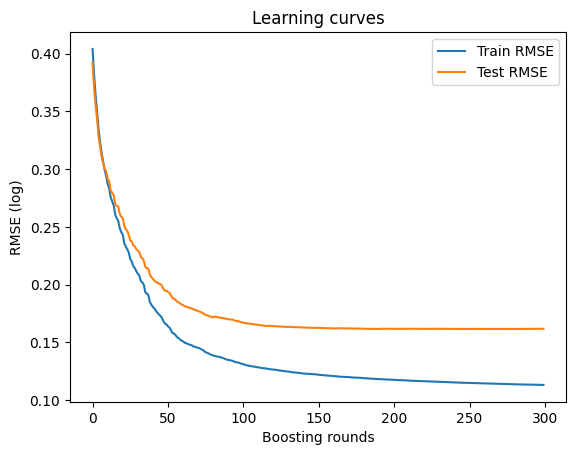

In [ ]:
eval_set = [(X_train, y_train), (X_test, np.log1p(y_test))] 
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=12,
    learning_rate=0.15,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse" 
)

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

results = model.evals_result()
train_errors = results["validation_0"]["rmse"]
test_errors = results["validation_1"]["rmse"]

import matplotlib.pyplot as plt
plt.plot(train_errors, label="Train RMSE")
plt.plot(test_errors, label="Test RMSE")
plt.title("Learning curves")
plt.xlabel("Boosting rounds")
plt.ylabel("RMSE (log)")
plt.legend()
plt.show()

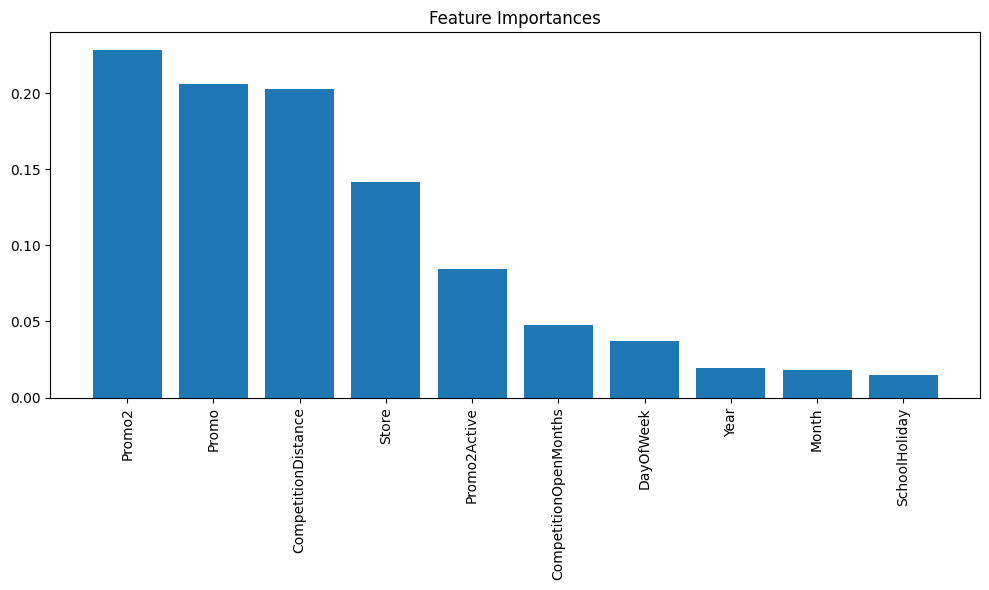

In [113]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [114]:
preds_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": np.expm1(model.predict(X_test))
})
print(preds_df.head())

   Actual    Predicted
0    5263  4132.238770
1    6064  4744.144531
2    8314  7209.242676
3   13995  8703.540039
4    4822  5017.074219
